In [1]:
import sympy
from sympy import Symbol, Sum, IndexedBase
from sympy.parsing.sympy_parser import parse_expr

In [2]:
a = IndexedBase("alpha", "i")
xr = IndexedBase("x_r", "i")
yr = IndexedBase("y_r", "i")
xl = IndexedBase("x_l", "i")
yl = IndexedBase("y_l", "i")

x = IndexedBase("x", "i")
y = IndexedBase("y", "i")

kp = Symbol("k_p")
kl = Symbol("k_l")

i = Symbol("i")
N = Symbol("N")

In [54]:
def print_latex(text, fontsize=50):
  lat = sympy.latex(text)

  #add text                                                                       
  plt.text(0, 0.5, r"$%s$" % lat, fontsize=fontsize)                                  

  # #hide axes                                                                      
  fig = plt.gca()
  fig.axis('off')
  plt.draw()

## Formulation

In [31]:
import matplotlib.pyplot as plt

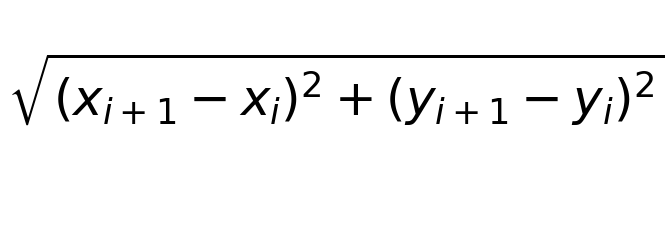

In [55]:
ds = sympy.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
print_latex(ds)

In [4]:
Jl = ds**2
Sum(Jl, ("i", 0, N))

Sum((x[i + 1] - x[i])**2 + (y[i + 1] - y[i])**2, (i, 0, N))

In [5]:
Jp = (sympy.atan((y[i+1]-y[i])/(x[i+1]-x[i]))-sympy.atan((y[i]-y[i-1])/(x[i]-x[i-1])))/(ds)
Sum(Jl, ("i", 1, N))

Sum((x[i + 1] - x[i])**2 + (y[i + 1] - y[i])**2, (i, 1, N))

## Substitutions

In [6]:
Jl = Jl \
    .subs(x[i+1], xr[i+1]+a[i+1]*(xr[i+1]-xl[i+1])) \
    .subs(x[i], xr[i]+a[i]*(xr[i]-xl[i])) \
    .subs(y[i], yr[i]+a[i]*(yr[i]-yl[i])) \
    .subs(y[i+1], yr[i+1]+a[i+1]*(yr[i+1]-yl[i+1]))
Sum(Jl, ("i", 1, N))

Sum(((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])**2 + ((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])**2, (i, 1, N))

In [7]:
Jp = Jp \
    .subs(x[i+1], xr[i+1]+a[i+1]*(xr[i+1]-xl[i+1])) \
    .subs(x[i], xr[i]+a[i]*(xr[i]-xl[i])) \
    .subs(x[i-1], xr[i-1]+a[i-1]*(xr[i-1]-xl[i-1])) \
    .subs(y[i], yr[i]+a[i]*(yr[i]-yl[i])) \
    .subs(y[i+1], yr[i+1]+a[i+1]*(yr[i+1]-yl[i+1])) \
    .subs(y[i-1], yr[i-1]+a[i-1]*(yr[i-1]-yl[i-1]))
Sum(Jp, ("i", 1, N))

Sum((atan(((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])/((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])) - atan((-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])))/sqrt(((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])**2 + ((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])**2), (i, 1, N))

In [16]:
J = kl*Sum(Jl, ("i", 1, N)) + kp * Sum(Jp, ("i", 1, N))
J

k_l*Sum(((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])**2 + ((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])**2, (i, 1, N)) + k_p*Sum((atan(((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])/((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])) - atan((-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])))/sqrt(((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])**2 + ((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])**2), (i, 1, N))

## Gradient

In [26]:
gradient = J.diff(a[i])
gradient

k_l*Sum((2*x_l[i] - 2*x_r[i])*((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i]) + (2*y_l[i] - 2*y_r[i])*((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i]), (i, 1, N)) + k_p*Sum((-((x_l[i] - x_r[i])*(-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])**2 + (-y_l[i] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i]))/(1 + (-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])**2/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])**2) + ((-x_l[i] + x_r[i])*((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])/((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x

In [22]:
gradient_jl = Jl.diff(a[i])
gradient_code_jl = sympy.ccode(gradient_jl) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i+1]", "alpha(idx+1)") \
    .replace("alpha[i-1]", "alpha(idx-1)") \
    .replace("pow", "power")
gradient_code_jl

'(2*leftpoints(idx, 1) - 2*rightpoints(idx, 1))*((-leftpoints(idx+1, 1) + rightpoints(idx+1, 1))*alpha[i + 1] - (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) + rightpoints(idx+1, 1) - rightpoints(idx, 1)) + (2*leftpoints(idx, 2) - 2*rightpoints(idx, 2))*((-leftpoints(idx+1, 2) + rightpoints(idx+1, 2))*alpha[i + 1] - (-leftpoints(idx, 2) + rightpoints(idx, 2))*alpha(idx) + rightpoints(idx+1, 2) - rightpoints(idx, 2))'

In [24]:
gradient_jp = Jp.diff(a[i])
gradient_code_jp = sympy.ccode(gradient_jp) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i+1]", "alpha(idx+1)") \
    .replace("alpha[i-1]", "alpha(idx-1)") \
    .replace("pow", "power")
gradient_code_jp

'(-((leftpoints(idx, 1) - rightpoints(idx, 1))*(-(-leftpoints(idx-1, 2) + rightpoints(idx-1, 2))*alpha[i - 1] + (-leftpoints(idx, 2) + rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/power(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2) + (-leftpoints(idx, 2) + rightpoints(idx, 2))/(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1)))/(1 + power(-(-leftpoints(idx-1, 2) + rightpoints(idx-1, 2))*alpha[i - 1] + (-leftpoints(idx, 2) + rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2), 2)/power(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2)) + ((-leftpoints(idx, 1) + rightpoints(idx

## Hessian

In [27]:
hessian = gradient.diff(a[i])
hessian

k_l*Sum((x_l[i] - x_r[i])*(2*x_l[i] - 2*x_r[i]) + (y_l[i] - y_r[i])*(2*y_l[i] - 2*y_r[i]), (i, 1, N)) + k_p*Sum(2*(-((x_l[i] - x_r[i])*(-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])**2 + (-y_l[i] + y_r[i])/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i]))/(1 + (-(-y_l[i - 1] + y_r[i - 1])*alpha[i - 1] + (-y_l[i] + y_r[i])*alpha[i] - y_r[i - 1] + y_r[i])**2/(-(-x_l[i - 1] + x_r[i - 1])*alpha[i - 1] + (-x_l[i] + x_r[i])*alpha[i] - x_r[i - 1] + x_r[i])**2) + ((-x_l[i] + x_r[i])*((-y_l[i + 1] + y_r[i + 1])*alpha[i + 1] - (-y_l[i] + y_r[i])*alpha[i] + y_r[i + 1] - y_r[i])/((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i])**2 + (y_l[i] - y_r[i])/((-x_l[i + 1] + x_r[i + 1])*alpha[i + 1] - (-x_l[i] + x_r[i])*alpha[i] + x_r[i + 1] - x_r[i]))/(1 + ((-y_l[i + 1] + y_r[

In [28]:
hessian_jl = gradient_jl.diff(a[i])
hessian_code_jl = sympy.ccode(hessian_jl) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i+1]", "alpha(idx+1)") \
    .replace("alpha[i-1]", "alpha(idx-1)") \
    .replace("pow", "power")
hessian_code_jl

'(leftpoints(idx, 1) - rightpoints(idx, 1))*(2*leftpoints(idx, 1) - 2*rightpoints(idx, 1)) + (leftpoints(idx, 2) - rightpoints(idx, 2))*(2*leftpoints(idx, 2) - 2*rightpoints(idx, 2))'

In [29]:
hessian_jp = gradient_jp.diff(a[i])
hessian_code_jp = sympy.ccode(hessian_jp) \
    .replace("x_l[i]", "leftpoints(idx, 1)") \
    .replace("x_l[i + 1]", "leftpoints(idx+1, 1)") \
    .replace("x_r[i]", "rightpoints(idx, 1)") \
    .replace("x_r[i + 1]", "rightpoints(idx+1, 1)") \
    .replace("y_l[i]", "leftpoints(idx, 2)") \
    .replace("y_l[i + 1]", "leftpoints(idx+1, 2)") \
    .replace("y_r[i]", "rightpoints(idx, 2)") \
    .replace("y_r[i + 1]", "rightpoints(idx+1, 2)") \
    .replace("x_l[i - 1]", "leftpoints(idx-1, 1)") \
    .replace("y_l[i - 1]", "leftpoints(idx-1, 2)") \
    .replace("x_r[i - 1]", "rightpoints(idx-1, 1)") \
    .replace("y_r[i - 1]", "rightpoints(idx-1, 2)") \
    .replace("alpha[i]", "alpha(idx)") \
    .replace("alpha[i+1]", "alpha(idx+1)") \
    .replace("alpha[i-1]", "alpha(idx-1)") \
    .replace("pow", "power")
hessian_code_jp

'2*(-((leftpoints(idx, 1) - rightpoints(idx, 1))*(-(-leftpoints(idx-1, 2) + rightpoints(idx-1, 2))*alpha[i - 1] + (-leftpoints(idx, 2) + rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2))/power(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2) + (-leftpoints(idx, 2) + rightpoints(idx, 2))/(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1)))/(1 + power(-(-leftpoints(idx-1, 2) + rightpoints(idx-1, 2))*alpha[i - 1] + (-leftpoints(idx, 2) + rightpoints(idx, 2))*alpha(idx) - rightpoints(idx-1, 2) + rightpoints(idx, 2), 2)/power(-(-leftpoints(idx-1, 1) + rightpoints(idx-1, 1))*alpha[i - 1] + (-leftpoints(idx, 1) + rightpoints(idx, 1))*alpha(idx) - rightpoints(idx-1, 1) + rightpoints(idx, 1), 2)) + ((-leftpoints(idx, 1) + rightpoints(i